<a href="https://colab.research.google.com/github/ryan-birm/FIRE298-Project/blob/main/Final_Notebook_Polar_Home_Depot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving the Image Classification of Polar Lows
### FIRE 298 Research Project - Polar Home Depot
Katie Fernon, Riya Kanani, Ryan Birmingham, Shraddha Patre

# Introduction

### Background
Polar lows are fast-forming mesocyclones that are capable of reaching hurricane-like forces (Terpstra and Watanabe). The shape of these storms can either be circular with an eye in the center or in the shape of a comma. The ability to identify these storms and notify coastal communities who may be affected could help them better prepare to face the storm's effects.

### Goals
The goal of our research is to improve the identification and classification of Polar Lows using machine learning models by expanding upon our final project from FIRE 198, further developing it to produce more accurate identification results. We will partially accomplish this by implementing a CNN model called AlexNet using the Pytorch framework. We found a guide for this implementation on GitHub written by Machine Learning Engineer Daniel Bourke (Bourke).

### Motivation
Our motivation is to improve automation the classification of satellite imagery data as a polar low or nonpolar low storm image for the sake of furthering technological improvement.

We are also motivated to help communities affected by polar lows which would be achieved through accurate identificaiton of the storms using satellite imagery.

# Initial Evaluation/Brainstorming

To begin our brainstorming process, we created a document to contribute each of our ideas for how to approach solving our research problem. We generated ideas by looking at research articles of image classfication models and previous models that were created by FIRE peer mentors. Upon deliberation, we attempted to implement three strategies: small image training, data dropping for our decision tree, and replacing the original images with IR/water image data.

We started with attempting to resize the images but found out that the pretrained models worked best with images of a certain size. From this we learned that we should continue by implementing a better model than the one we had used before - Google Teachable Machine. After doing some research, we decided that a  model would be AlexNet as it has a high accuracy with our dataset.

#Dependencies

In order to implement our various research methods, we will need to use the following libraries.

In [ ]:
# Everyone

# import statements

from google.colab import drive  # We import drive so that we can mount our FIRE-CC drive to the Colab environment
drive.mount('/content/drive') # this command is how we tell google we have permission to access the data on drive
import pickle # Use to download pkl dataframe files from drive
import pandas as pd # Pandas for manipulating dataframes
import os
from sklearn.model_selection import train_test_split
import shutil # Bringing files into drive
from PIL import Image, ImageOps # Used for image processing operations
import keras
import torch
import torchvision
from torchvision import transforms
import tensorflow as tf
from keras.preprocessing import image
import numpy as np  # Numpy; for efficient calculations
from keras.applications.imagenet_utils import preprocess_input # Used for training and prediction processes with models, filters images to desired criteria

#AlexNet imports
!git clone https://github.com/mrdbourke/pytorch-deep-learning
!mv pytorch-deep-learning/going_modular .
!rm -rf pytorch-deep-learning
from going_modular.going_modular import data_setup, engine

from tqdm.auto import tqdm

try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3297, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 3297 (delta 137), reused 229 (delta 110), pack-reused 3020
Receiving objects: 100% (3297/3297), 642.58 MiB | 36.98 MiB/s, done.
Resolving deltas: 100% (1867/1867), done.
Checking out files: 100% (221/221), done.
mv: cannot move 'pytorch-deep-learning/going_modular' to './going_modular': Directory not empty
mlxtend version: 0.21.0
0.21.0


#Data Cleaning

We will create a dataframe containing information corresponding with each image we will be using for testing and training. We will also bring in images from Snapshots and NonPolarLowSnapshots folders to our Polar Home Depot folder to use as source folders.

NOTE: These images were later moved into differently named folders because we wanted to reorganize our directories.

In [ ]:
# Katie

# Read in of dataframe for Spring 2020, 2021, and 2022
# File paths for each pickle file
#this includes all of the clean images of size 1000 x 1000 pixels
pickle_path_2022 = '/content/drive/Shareddrives/FIRE-CC/pkl files/Spring2022PolarLowsClean.pkl'
pickle_path_2021 = '/content/drive/Shareddrives/FIRE-CC/pkl files/Spring2021PolarLowsClean.pkl'
pickle_path_2020= '/content/drive/Shareddrives/FIRE-CC/pkl files/Spring2020PolarLowsClean.pkl'

#loads the dataframe in the pickle files into our dataframe
with open(pickle_path_2022, 'rb') as f:
  df_2022 = pickle.load(f)
with open(pickle_path_2021, 'rb') as f:
  df_2021 = pickle.load(f)
with open(pickle_path_2020, 'rb') as f:
  df_2020 = pickle.load(f)

# Change df_2020 columns to match 2021 and 2022
df_2020 = pd.DataFrame(df_2020[['your last name', 'date of Polar Low Occurance', 'Aqua or Terra?',
       'How confident are you that this is actually a polar low [1 for low, 2 for high]',
       'latitude of box top', 'longitude of box right side',
       'latitude of box bottom', 'longitude of box left side',
       'file name of PNG']])
df_2020.columns = df_2022.columns.values

# Combine all data from each year into one dataframe
frames = [df_2022, df_2021, df_2020]
df_all = pd.concat(frames)
df_all.reset_index(inplace=True, drop=True)

df_all.head()

,your last name,date of Polar Low Occurance,Aqua or Terra?,"How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]",latitude of box top,longitude of box right side,latitude of box bottom,longitude of box left side,file name of PNG
0,Starr,08/11/2020,Terra,2,-57.94,-144.555,-66.748,-153.348,200811_HS1.png
1,Starr,08/11/2020,Terra,2,-58.15,-130.43,-66.98,-139.22,200811_HS2.png
2,Starr,08/10/2020,Terra,2,-51.66,-143.26,-60.43,-152.06,200810_HS1.png
3,Starr,08/13/2020,Terra,2,-53.31,-58.41,-62.11,-67.23,200813_HS1.png
4,Starr,08/14/2020,Terra,2,-59.4,-79.76,-68.26,-88.58,200814_HS1.png


We took previous semesters filtered pickle files and used the image files in the dataframe to create polar low and non polar low lists

The images that were listed in the pickle file were in the Snapshots and NonPolarLowSnaphots folder in our Google drive. We took those images and put then into two lists: PL_files and NPL_files. We then used the lists to organize the image files into our drive into polar low and non polar low image folders. We commented out the code to create the folders so that it would not create new folders within the drive every time we run the code. We will later use these images as our testing and training data for our model.

In [ ]:
# Katie

# Gather file names of all image files in Google Drive. We want to have files only of file names provided in our data frame.
og_snapshot_files = os.listdir('/content/drive/Shareddrives/FIRE-CC/Polar Lows/Snapshots/')
og_NPLsnapshot_files = os.listdir('/content/drive/Shareddrives/FIRE-CC/Polar Lows/NonPolarLowSnapshots/')
images = df_all['file name of PNG'].tolist()

PL_files = []
NPL_files = []
#adds to the list all of the images which are in the polar lows folder which are also
#in the dataframe of clean images gotten from the pickle file.
for file in og_snapshot_files:
  if file in images:
    PL_files.append(file)

#adds to the list all of the images which are in the non polar lows folder
#which are also in the dataframe of clean images gotten from the pickle file.
for file in og_NPLsnapshot_files:
  if file in images:
    NPL_files.append(file)

if ((len(PL_files) + len(NPL_files)) == df_all.shape[0]):
  print("Total number of files in folders is equal to number of data entries in data frame.")
  print(df_all.shape[0])
  print("Number of total PL files to from the dataframe: ")
  print(len(PL_files))
  print("Number of total NPL files to from the dataframe: ")
  print(len(NPL_files))
else:
  print("The number of files is not correct.")

## Copy images from Snapshots and NonPolarLowSnapshots folders to our own folders (only needs to be done once)

## PL images
#source = PL_files
#i = 0
#for image in PL_files:
#  source = '/content/gdrive/Shareddrives/FIRE-CC/Polar Lows/Snapshots/' + str(PL_files[i])
#  destination = '/content/gdrive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/Teachable Machine v1/PL_files/'
#  shutil.copy(source, destination)
#  i = i + 1

## NPL images
#source = NPL_files
#i = 0
#for image in NPL_files:
#  source = '/content/gdrive/Shareddrives/FIRE-CC/Polar Lows/NonPolarLowSnapshots/' + str(NPL_files[i])
#  destination = '/content/gdrive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/Teachable Machine v1/NPL_files/'
#  shutil.copy(source, destination)
#  i = i + 1


Total number of files in folders is equal to number of data entries in data frame.
696
Number of total PL files to from the dataframe: 
489
Number of total NPL files to from the dataframe: 
207


The block of code below creates lists for testing and training both polar low and non polar low images. It then imported those images into folders within our Google drive. This code is commented out so it does not create duplicate folders each time it is run.

In [ ]:
# Katie

# Testing and Training split with original sized data
# Data is spit 80% training and 20% testing

# Splitting test/train data for PL files
PL_x = PL_files
PL_y = []
for index in PL_x:
  PL_y.append('PL')
PL_x_train, PL_x_test, PL_y_train, PL_y_test = train_test_split(PL_x, PL_y, test_size=0.20, random_state=42)

# Splitting test/train data for NPL files
NPL_x = NPL_files
NPL_y = []
for index in NPL_x:
  NPL_y.append('NPL')
NPL_x_train, NPL_x_test, NPL_y_train, NPL_y_test = train_test_split(NPL_x, NPL_y, test_size=0.20, random_state=42)


## Copy images from testing and training split into our drive folders (only needs to be run once)
## *** Folders have since been manipulated and change so will not be exactly reflected in drive

## PL training images
#source = PL_x_train
#i = 0
#for image in PL_x_train:
#  source = '/content/gdrive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/Teachable Machine v1/PL_files/' + str(PL_x_train[i])
#  destination = '/content/gdrive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/Teachable Machine v1/training/PL/'
#  shutil.copy(source, destination)
#  i = i + 1

## PL testing images
#source = PL_x_test
#i = 0
#for image in PL_x_test:
#  source = '/content/gdrive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/Teachable Machine v1/PL_files/' + str(PL_x_test[i])
#  destination = '/content/gdrive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/Teachable Machine v1/testing/PL/'
#  shutil.copy(source, destination)
#  i = i + 1

## NPL training images
#source = NPL_x_train
#i = 0
#for image in NPL_x_train:
#  source = '/content/gdrive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/Teachable Machine v1/NPL_files/' + str(NPL_x_train[i])
#  destination = '/content/gdrive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/Teachable Machine v1/training/NPL/'
#  shutil.copy(source, destination)
#  i = i + 1

## NPL testing images
#source = NPL_x_test
#i = 0
#for image in NPL_x_test:
#  source = '/content/gdrive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/Teachable Machine v1/NPL_files/' + str(NPL_x_test[i])
#  destination = '/content/gdrive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/Teachable Machine v1/testing/NPL/'
#  shutil.copy(source, destination)
#  i = i + 1


# Data Preparation for AlexNet Model

**Settings to pick random images - affects droput layer functionality (Bourke)**

In [ ]:
#Set the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

**Transforming the images to the needed dimensions so that the model can work with it (Bourke)**

Since this model is pretrained, we must normalize each image. This means that we need to transform our images to be like the original images which the model was trained on. This function will turn all of our images into size 224 x 224.

In [ ]:
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

**Loading in the testing and training datasets from drive**

We had an 80-20 train-test split. **There are 555 training images and 139 testing images.** Here we use the paths train_dir and test_dir to create dataloaders which will later on be used to train our model.  

In [ ]:
# Riya

# Create training and testing DataLoader's as well as get a list of class names
train_dir = '/content/drive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/All_Images_wTestTrain/training_subs'
test_dir = '/content/drive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/All_Images_wTestTrain/testing_subs'
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x7f3ae66accd0>,
 ['NPL', 'PL'])

# Training and Testing of Methods and Models

## AlexNet Transfer Learning Implementation

**Loading in a PyTorch pre-trained model.**

In [ ]:
# Shraddha

device = "cuda" if torch.cuda.is_available() else "cpu"
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True).to(device)
model.eval()

**Prepare the model to work for our purposes.**

Here we are freezing some layers in the model. This is because we do not want the weights associated with these layers to be changed during training.

In [ ]:
# Shraddha

# freeze the base layers in the features section
for param in model.features.parameters():
    param.requires_grad = False

The original AlexNet model can classify images into a thousand classes, but we only want it to classify our images as polar lows or non-polar lows (two classes). Here, we make this adjustment to the model by specifying the number of out_features as 2.

In [ ]:
# Shraddha

# Changing the last layer to have only two classes
output_shape = 2
model.classifier = torch.nn.Sequential(
  torch.nn.Dropout(p=0.2, inplace=True),
  torch.nn.Linear(in_features=9216,
                  out_features= 2, # same number of output units as our number of classes
                  bias=True)).to(device)

**Train model to work with our data.**

Here we are defining the loss function that our model will run with (Bourke)

In [ ]:
# Define loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
#adjust the learning rate to 0.0001 for a higher AlexNet accuracy (may not be a higher overall accuracy)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

This function trains the model. Epochs represents the number of times the training dataset runs through the model.

In [ ]:
# Riya

model_results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader= test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9267 | train_acc: 0.7348 | test_loss: 0.5727 | test_acc: 0.8210
Epoch: 2 | train_loss: 0.3501 | train_acc: 0.8804 | test_loss: 0.5112 | test_acc: 0.8830
Epoch: 3 | train_loss: 0.1579 | train_acc: 0.9444 | test_loss: 0.4786 | test_acc: 0.8705
Epoch: 4 | train_loss: 0.0675 | train_acc: 0.9774 | test_loss: 0.4720 | test_acc: 0.8824
Epoch: 5 | train_loss: 0.0376 | train_acc: 0.9913 | test_loss: 0.4740 | test_acc: 0.9131


###Make Predictions



Here, we are running the testing data through the model and obtaining the predictions from AlexNet.

In [ ]:
# Make predictions on the entire test dataset
test_preds = []
model.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/5 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Visual Analysis for AlexNet Model Results

In [ ]:
# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

A confusion matrix is created in order to determine the accuracy of the AlexNet model,. The Confusion matrix displays the number of correctly and incorrectly classified polar lows images and the number of correctly and incorrectly classified non polar lows images. From the confusion matrix, it can be concluded that the model can correctly predict 97% of PL images and 77% of NPL images.

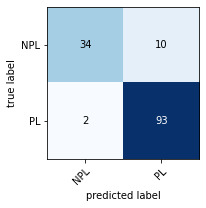

In [ ]:
# Riya

# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(4, 2.8)
)

## AlexNet Model Performance


An epoch is the number of times that the model runs through the entire dataset.
The graphs below will compare this hyperparameter with two different indicators of how well our model works.

### Epochs vs. Loss (Bourke)

Loss is the summation of errors that our model produces. This graph will compare the training loss and the testing loss as the number of epochs increases. A model with a lower loss is considered better than one with a higher loss.

### Epochs vs. Accuracy (Bourke)

Accuracy is the number of images our model correctly identifies. This graph will compare the training and testing accuracy as the number of epochs increases. The higher the accuracy, the better the model.

We are creating these graphs in order to determine the best number of epochs to use when testing and training our images. The goal is to find an epoch in which the accuracy is high and loss is low while also avoiding overfitting. Overfitting can occur when a model is trained on the same images too many times and has trouble predicting images outside of the training dataset.

[INFO] Couldn't find helper_functions.py, downloading...


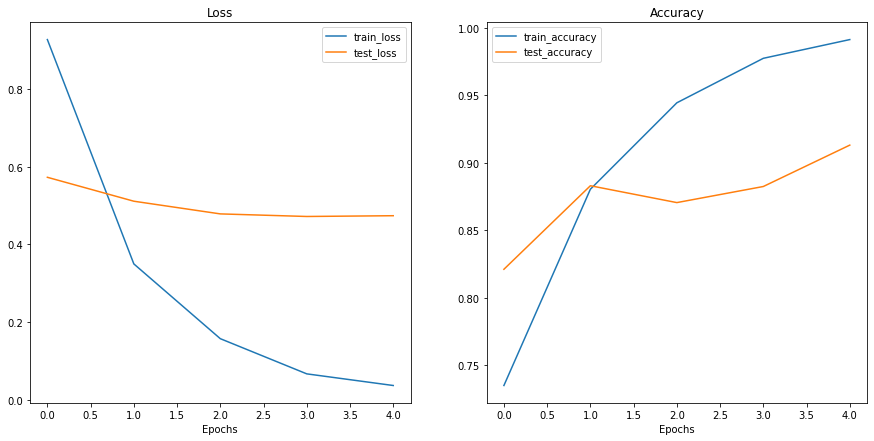

In [ ]:
# Riya

# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(model_results)


According to the graph, the testing loss doesn’t change much as the number of epochs increases, however, the training loss decreases significantly. Additionally, testing accuracy decreases slightly as the number of epochs increases, however, the training accuracy increases significantly.

From the graphs we can conclude to not run our model with more than 5 epochs for two reasons:

1) Since AlexNet is a pre-trained CNN, a large number of epochs is not necessary to train the model on our dataset.

2) When we train the model with a larger number of epochs, it begins to overfit, possibly because of the smaller size of our dataset.

# Data for Decision Tree

Decision trees are another type of supervised learning that we will implement to further improve the accuracy of classifying our satellite imagery.

We plan to take the numeric prediction result from each testing image along with the image's latitude and longitude data (retrieved from our original dataframe df_all) and feed it into the tree to produce an even more exact classification.


The following code turns our model predictions into a dictionary with the following data attributed to each image: the image path,	class name,	predition probability, prediction class, and if it was correctly classified.

In [ ]:
# Riya

# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.png"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path).convert('RGB') # open image, added .convert to match tensor sizes
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class

    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model,
                                 transform=simple_transform,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5] # show portion of list of dictionaries

In [ ]:
# Riya

import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,correct
0,/content/drive/Shareddrives/FIRE-CC/FIRE298/20...,PL,0.999588,PL,True
1,/content/drive/Shareddrives/FIRE-CC/FIRE298/20...,PL,0.834308,PL,True
2,/content/drive/Shareddrives/FIRE-CC/FIRE298/20...,PL,0.999881,PL,True
3,/content/drive/Shareddrives/FIRE-CC/FIRE298/20...,PL,1.000000,PL,True
4,/content/drive/Shareddrives/FIRE-CC/FIRE298/20...,PL,0.964951,PL,True


Now, we take the metadata of the testing images from the df_all dataframe for our testing images and extract what features we would like to feed into the decision tree along with the AlexNet classification: latitude and longitude data.  

In [ ]:
# Katie

# Get file names of files tested by AlexNet

paths = test_pred_df['image_path'].tolist()
print(paths)

stringFilePaths = []
for i in paths:
  stringPath = str(i)
  filePath = os.path.basename(stringPath)
  stringFilePaths.append(filePath)

print(stringFilePaths)

[PosixPath('/content/drive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/All_Images_wTestTrain/testing_subs/PL/201226_SP1.png'), PosixPath('/content/drive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/All_Images_wTestTrain/testing_subs/PL/181021_RJ1.png'), PosixPath('/content/drive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/All_Images_wTestTrain/testing_subs/PL/191101_RB2.png'), PosixPath('/content/drive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/All_Images_wTestTrain/testing_subs/PL/191214_AM3.png'), PosixPath('/content/drive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/All_Images_wTestTrain/testing_subs/PL/191127_VG4.png'), PosixPath('/content/drive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/All_Images_wTestTrain/testing_subs/PL/200702_TG4.png'), PosixPath('/content/drive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Home Depot/All_Images_wTestTrain/testing_subs/PL/180727_RM2.png'), PosixPath('/content/drive/Shareddrives/FIRE-CC/FIRE298/2022/Polar Ho

In [ ]:
# Katie

# Get dataframe with data associated with each file tested by AlexNet

rowIndicesNeeded = []
for i in stringFilePaths:
  rowIndicesNeeded.append(df_all[df_all['file name of PNG'] == i].index[0])

print("Amount of rows (testing images) in df: " + str(len(rowIndicesNeeded)))

df_testing = pd.DataFrame()

for i in rowIndicesNeeded:
  df_testing = df_testing.append(df_all.iloc[i])

df_testing.reset_index(inplace=True, drop=True)
df_testing = df_testing[["longitude of box right side", "latitude of box top", "file name of PNG", "How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]"]]

df_testing.head()

[130, 610, 108, 159, 94, 379, 485, 499, 172, 527, 500, 619, 12, 689, 199, 600, 96, 103, 311, 680, 439, 627, 14, 666, 437, 438, 582, 453, 417, 287, 444, 651, 389, 241, 501, 603, 547, 581, 525, 641, 37, 46, 56, 584, 436, 645, 494, 117, 178, 68, 432, 468, 274, 583, 602, 154, 570, 300, 457, 66, 676, 378, 216, 594, 567, 558, 21, 76, 590, 255, 123, 162, 440, 353, 392, 608, 537, 377, 372, 402, 177, 411, 360, 669, 605, 102, 492, 684, 327, 496, 393, 321, 668, 545, 51, 175, 50, 115, 374, 345, 325, 145, 358, 281, 82, 231, 98, 136, 384, 87, 176, 60, 180, 143, 158, 318, 198, 42, 135, 268, 282, 209, 406, 324, 229, 17, 118, 86, 388, 348, 43, 97, 329, 15, 146, 302, 31, 347, 147]
Amount of rows in df: 139


,longitude of box right side,latitude of box top,file name of PNG,"How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]"
0,-80.4512,-59.7966,201226_SP1.png,1
1,8.19,76.7,181021_RJ1.png,2
2,-164.6522,-51.6963,191101_RB2.png,2
3,91.4027,-47.1526,191214_AM3.png,2
4,169.7079,-54.9248,191127_VG4.png,1


##Decision Tree Implementation

The decision tree is created to further classify the images based on the latitude and longitude of the image. For a polar low to be considered a polar low, it has to be either above 40 degrees latitude or below -40 degrees latitude. We believe that through creating a decision tree, we will be able to fine tune our model based on the definition of a polar low. Our goal is to improve the accuracy when comparing to just using Alexnet predictions alone.

After running AlexNet and classifying the images, we ran the AlexNet image predictions, stored in an array named “master”, through our decision tree. For the depth of our decision tree, we made it equal to 2 to avoid overfitting data.

In [ ]:
# Riya

prediction_array = [[]]
i = 0

#temp_df is what we use later in order to train our decision tree
#used df_testing which contains data associated with images tested in AlexNet
#also used the true classification labels in temp_df
temp_df = df_testing[["latitude of box top", "longitude of box right side", "How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]"]]
list_long = list(temp_df["longitude of box right side"])
list_lat = list(temp_df["latitude of box top"])
#turns all the 2's into 1's so it is either 0 or 1, this is because polar lows are classified as both 2 and 1.
#later, we can just use 0 and 1. using 0, 1, and 2, makes things redundant and matches up with the models classification labels.
list_class = np.array(list(temp_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]']))
list_class[list_class == '2'] = '1'

#master is an array that will be passed into the decision tree containing the AlexNet predictions,
#latitude data, and longitude data.
master = []
#for all the images in all the lists: long, lat, and prediction, makes it into 1 still
for i in range(len(test_preds)):
  master.append([test_preds[i], float(list_long[i]), float(list_lat[i])])
print(master)

[[tensor(0), -80.4512, -59.7966], [tensor(0), 8.19, 76.7], [tensor(0), -164.6522, -51.6963], [tensor(0), 91.4027, -47.1526], [tensor(1), 169.7079, -54.9248], [tensor(0), 19.6885, -47.0691], [tensor(0), 143.9027, -45.4871], [tensor(0), -105.3919, -57.141], [tensor(0), 106.3232, -45.1154], [tensor(0), -114.5975, -46.2461], [tensor(0), -69.9701, -56.7218], [tensor(0), -7.0313, -53.5605], [tensor(0), -142.7567, 49.5112], [tensor(0), 81.472, -47.2363], [tensor(1), -171.813, -36.7672], [tensor(0), -16.9, -43.6], [tensor(1), -30.9027, -41.4015], [tensor(0), -145.2842, 55.5791], [tensor(0), -85.8096, -46.9497], [tensor(0), 141.4466, -45.7865], [tensor(0), 36.2109, -47.083], [tensor(0), 96.6533, -54.3867], [tensor(0), -156.915, 53.5063], [tensor(0), 87.3281, -42.3984], [tensor(0), 143.2969, -49.3418], [tensor(0), -154.1777, -39.4893], [tensor(0), -33.4688, -48.0586], [tensor(0), -29.7185, -44.1125], [tensor(0), 127.222, -43.9112], [tensor(0), -135.6123, 49.3222], [tensor(0), -138.4453, 61.5322]

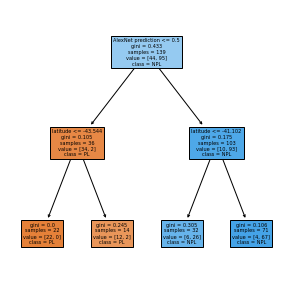

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt  # Matplotlib will allow us to make visuals of our data and display images

#creates a tree of depth 2, if we have too many depths, it overfits (meaning it
#trains so well that it only does well on the actual training set)
#generalization: applying trained model to test data
# the tree is a decision maker, it goes down a path to determine the decision.
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(master, test_truth) # fitting tree with AlexNet predictions and truth labels
fig = plt.figure(figsize=(15,15))
_ = tree.plot_tree(clf, feature_names=['AlexNet prediction', 'longitude', 'latitude'], class_names=['PL', 'NPL'], filled=True)

In [ ]:
# Riya

# test set process
# for a test set, we used the 2022 data as the training data
# we made a confusion matrix
temp_df = df_testing[["latitude of box top", "longitude of box right side", "How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]"]]
list_long = list(temp_df["longitude of box right side"])
list_lat = list(temp_df["latitude of box top"])
list_class = np.array(list(temp_df['How confident are you that this is actually a polar low [1 for low, 2 for high, 0 for definitely not a polar low]']))
list_class[list_class == '2'] = '1'
test_Y = list(list_class.astype(int))

test_X = []
i = 0
for i in range(len(list_long)):
  tmp_lst = [int(list_class[i]), float(list_long[i]), float(list_lat[i])]
  test_X.append(tmp_lst)

pr = clf.predict(test_X)
pr = pr.tolist()

A confusion matrix is created to determine the accuracy of the decision tree given inputed AlexNet model prediction data. The matrix displays the number of correctly and incorrectly classified polar lows images and the number of correctly and incorrectly classified non-polar lows images. From the confusion matrix, it can be concluded that the accuracy of the model is 100%, given we only tested with 139 images.

The accuracy score of the model is 1.0
The precision score for predicting polar lows is 1.0
The precision score for predicting non-polar lows is 1.0


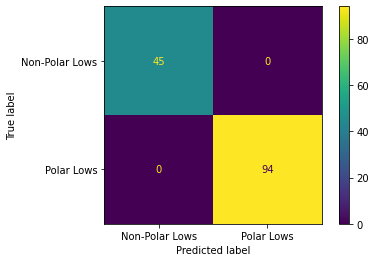

In [ ]:
# Katie

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score
#AlexNet results.
cm = confusion_matrix(test_Y, pr, labels=[0, 1])

#Accuracy Score
y_pred = pr

accuracy = accuracy_score(test_Y,pr)

print("The accuracy score of the model is " + str(accuracy))

#Precision Score
precision = precision_score(test_Y, pr, average=None)

print("The precision score for predicting polar lows is " + str(precision[0]))
print("The precision score for predicting non-polar lows is " + str(precision[1]))

#Displaying the Confusion Matrix
## Used defined labels from labels.txt in the converted_keras folder in the drive
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Polar Lows', 'Polar Lows'])
disp.plot()
plt.show()

#Final Results and Conclusions

We implemented the AlexNet CNN model and re-trained it with 5 epochs at a learning rate of 0.001. The raw predictions from this model were fed into the decision tree that was created in Spring 2022.
  
The accuracy of Alexnet alone improves the classification of polar lows from the teachable machine from 73% to around 81%. When implementing the decision tree, the model further improved to 100%.

We have faith in our model's accuracy reports, except we are a bit skeptical that the final result was 100%. This overestimated accuracy may be due to a low amount of testing data - we only used 139 images to feed into the decision tree.

For future research, the classification of polar lows can be improved by editing the hyperparameters such as the epochs, the loss function, or the layers in the decision tree. Additionally, data dropping can be implemented. Data can be randomly dropped during training to avoid overfitting. We are also interested in implementing more features to the decision tree for the image to be evaluated on before making a final classification prediction.

NOTE: There may be some discrepancies in the accuracy of our model. After looking at the training and testing split data, we found a few images that were mislabeled in the data frame, duplicates, or in the wrong folder. This messed up the 80-20 training testing split for both the non-polar low and polar low images.


#**Bibliography**

Bourke, D. (2022). PyTorch Transfer Learning.	https://github.com/mrdbourke/pytorch-deep-learning/blob/main/06_pytorch_transfer_learning.ipynb

(2022). TORCH.NN. PyTorch Contributors. https://pytorch.org/docs/stable/nn.html#loss-functions.

Terpstra, A., & Watanabe, S. Polar Lows. Oxford Research Encyclopedia of Climate Science. Retrieved 6 May. 2022, from https://oxfordre.com/climatescience/view/10.1093/acrefore/9780190228620.001.0001/acrefore-9780190228620-e-775.
